<a href="https://colab.research.google.com/github/deniskunev/KunevDenis2/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6_(%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/heart.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   CHOL_50    200 non-null    int64
 7   SES        200 non-null    int64
 8   CL_STATUS  200 non-null    int64
 9   MD_62      200 non-null    int64
 10  SBP_62     200 non-null    int64
 11  DBP_62     200 non-null    int64
 12  CHOL_62    200 non-null    int64
 13  WT_62      200 non-null    int64
 14  IHD_DX     200 non-null    int64
 15  DEATH      200 non-null    int64
dtypes: int64(16)
memory usage: 25.1 KB


### Преобразование категориальных фич

In [3]:
# # Создаем копию данных
# category_columns: list[str] = df.select_dtypes(include=['object']).columns # собираем колонки помеченные как objects

# # Применяем One-Hot Encoding
# df = pd.get_dummies(df, columns=category_columns, drop_first=True)
# df.type_white = df.type_white.astype(int)
df['AGE_50'] = df['AGE_50'].astype('category')
df['MD_50'] = df['MD_50'].astype('category')
df['SES'] = df['SES'].astype('category')
df['CL_STATUS'] = df['CL_STATUS'].astype('category')
df['MD_62'] = df['MD_62'].astype('category')
df['IHD_DX'] = df['IHD_DX'].astype('category')
df['SBP_62'] = df['SBP_62'].astype('category')
df['DBP_62'] = df['DBP_62'].astype('category')
df['CHOL_62'] = df['CHOL_62'].astype('category')
df['WT_62'] = df['WT_62'].astype('category')

### Преобразование непрерывных фич

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df = df[numeric_features]

In [5]:
df

,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,DEATH
0,0.180328,0.264706,0.214286,0.279412,0.412048,1.0
1,0.344262,0.333333,0.571429,0.426471,0.380723,1.0
2,0.262295,0.509804,0.642857,0.830882,0.534940,1.0
3,0.262295,0.411765,0.785714,0.882353,0.286747,1.0
4,0.245902,0.352941,0.357143,0.183824,0.296386,1.0
...,...,...,...,...,...,...
195,0.221311,0.411765,0.357143,0.286765,0.433735,0.0
196,0.180328,0.313725,0.571429,0.205882,0.000000,0.0
197,0.344262,0.411765,0.357143,0.301471,0.216867,0.0
198,0.426230,0.450980,0.357143,0.213235,0.024096,0.0


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [6]:
! pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 2  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'SBP_50':
             mean       std       min       max
Cluster                                        
0        0.325948  0.155931  0.098361  0.918033
1        0.288995  0.143914  0.000000  1.000000

Статистика для признака 'DBP_50':
             mean       std       min       max
Cluster                                        
0        0.443934  0.115414  0.264706  1.000000
1        0.445358  0.104539  0.000000  0.705882

Статистика для признака 'HT_50':
             mean       std       min       max
Cluster                                        
0        0.498884  0.204616  0.071429  0.928571
1        0.517332  0.194889  0.000000  1.000000

Статистика для признака 'WT_50':
             mean       std       min       max
Cluster                                        
0        0.416131  0.231895  0.000000  0.926471
1        0.442961  0.176723  0.080882  1.000000

Статистика для признака 'CHOL_50':
             mean       std      

#### **Анализ кластеров**



После применения алгоритма K-means с количеством кластеров \( k=3 \), мы получили три группы вин с заметными отличиями по некоторым признакам. Рассмотрим три наиболее значимых признака, по которым кластеры существенно различаются:

1. **Type_White (Тип вина):**
   - **Кластер 0** и **Кластер 1** полностью состоят из белых вин (значение `mean = 1.0`).
   - **Кластер 2** состоит исключительно из красных вин (значение `mean = 0.0`).

2. **Alcohol (Содержание алкоголя):**
   - **Кластер 0** имеет самое высокое среднее содержание алкоголя (`mean ≈ 0.533`).
   - **Кластер 1** имеет самое низкое среднее содержание алкоголя (`mean ≈ 0.239`).
   - **Кластер 2** находится между ними (`mean ≈ 0.351`).
   - **Вывод:** Белые вина в Кластере 0 более крепкие, тогда как в Кластере 1 — менее крепкие. Красные вина в Кластере 2 имеют среднее содержание алкоголя.

3. **Residual Sugar:**
   - **Кластер 1** обладает самым высоким средним значением остаточного сахара (`mean ≈ 0.117`), что заметно выше, чем в Кластерах 0 и 2 (`mean ≈ 0.051` и `mean ≈ 0.030` соответственно).
   - **Вывод:** Белые вина в Кластере 1 более сладкие, в то время как белые вина в Кластере 0 и красные вина в Кластере 2 менее сладкие.

**Коэффициент силуэта для \( k=3 \): 0.3420**

Коэффициент силуэта — это метрика для оценки качества кластеризации, показывающая, насколько объекты внутри одного кластера похожи друг на друга и отличаются от объектов в других кластерах.

- **Диапазон значений:** от -1 до 1.
  - **Близкие к 1:** Хорошая кластеризация; объекты внутри кластеров схожи, кластеры хорошо разделены.
  - **Около 0:** Кластеры пересекаются; объекты находятся на границах кластеров.
  - **Отрицательные значения:** Плохая кластеризация; объекты могут быть отнесены к неправильным кластерам.

**Интерпретация полученного значения:**

- **0.3420** — это положительное значение, указывающее на удовлетворительное качество кластеризации.
- Кластеры достаточно хорошо разделены, но есть пересечение между ними.

Кластеризация позволила выделить группы вин, отличающиеся по типу (белое или красное), содержанию алкоголя и уровню остаточного сахара.







1. SBP_50 (Систолическое артериальное давление):

   • Кластер 0: Среднее 0.3259, стандартное отклонение 0.1559, минимальное значение 0.0984, максимальное 0.9180.

   • Кластер 1: Среднее 0.2890, стандартное отклонение 0.1439, минимальное значение 0.0000, максимальное 1.0000.

   • Вывод: Кластер 0 имеет немного более высокое среднее значение, чем кластер 1, что может указывать на более высокие уровни систолического давления в этом кластере.

2. DBP_50 (Диастолическое артериальное давление):

   • Кластер 0: Среднее 0.4439, стандартное отклонение 0.1154, минимальное значение 0.2647, максимальное 1.0000.

   • Кластер 1: Среднее 0.4454, стандартное отклонение 0.1045, минимальное значение 0.0000, максимальное 0.7059.

   • Вывод: Средние значения диастолического давления практически одинаковы, но кластер 1 имеет более низкое максимальное значение.

3. HT_50 (Рост):

   • Кластер 0: Среднее 0.4989, стандартное отклонение 0.2046, минимальное значение 0.0714, максимальное 0.9286.

   • Кластер 1: Среднее 0.5173, стандартное отклонение 0.1949, минимальное значение 0.0000, максимальное 1.0000.

   • Вывод: Кластер 1 имеет чуть более высокое среднее значение роста.

4. WT_50 (Вес):

   • Кластер 0: Среднее 0.4161, стандартное отклонение 0.2319, минимальное значение 0.0000, максимальное 0.9265.

   • Кластер 1: Среднее 0.4430, стандартное отклонение 0.1767, минимальное значение 0.0809, максимальное 1.0000.

   • Вывод: Кластер 1 также показывает более высокое среднее значение веса.

5. CHOL_50 (Холестерин):

   • Кластер 0: Среднее 0.3268, стандартное отклонение 0.1402, минимальное значение 0.0916, максимальное 1.0000.

   • Кластер 1: Среднее 0.3356, стандартное отклонение 0.1311, минимальное значение 0.0000, максимальное 0.7687.

   • Вывод: Кластер 1 имеет чуть более высокое среднее значение уровня холестерина.

6. DEATH (Смерть):

   • Кластер 0: Все значения равны единице (смерть произошла).

   • Кластер 1: Все значения равны нулю (смерти не произошло).

   Это ключевая разница между кластерами — кластер 0 включает только случаи со смертью, в то время как кластер 1 включает только выживших.

Коэффициент силуэта

•Коэффициент силуэта для k=2: 0.5831 - это положительное значение, указывающее на удовлетворительное качество кластеризации. Значение в диапазоне от 0 до 1 говорит о том, что кластеры имеют хорошую плотность и достаточно четкое разделение.

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 2
Статистика по кластерам:

Статистика для признака 'SBP_50':
             mean       std       min       max  count
Cluster                                               
0        0.326958  0.156972  0.098361  0.918033     63
1        0.288995  0.143914  0.000000  1.000000    136

Статистика для признака 'DBP_50':
             mean       std       min       max  count
Cluster                                               
0        0.444444  0.116269  0.264706  1.000000     63
1        0.445358  0.104539  0.000000  0.705882    136

Статистика для признака 'HT_50':
             mean       std       min       max  count
Cluster                                               
0        0.498866  0.206260  0.071429  0.928571     63
1        0.517332  0.194889  0.000000  1.000000    136

Статистика для признака 'WT_50':
             mean       std       min       max  count
Cluster                                               
0        0.415149  0.233623  0.000000  0.92

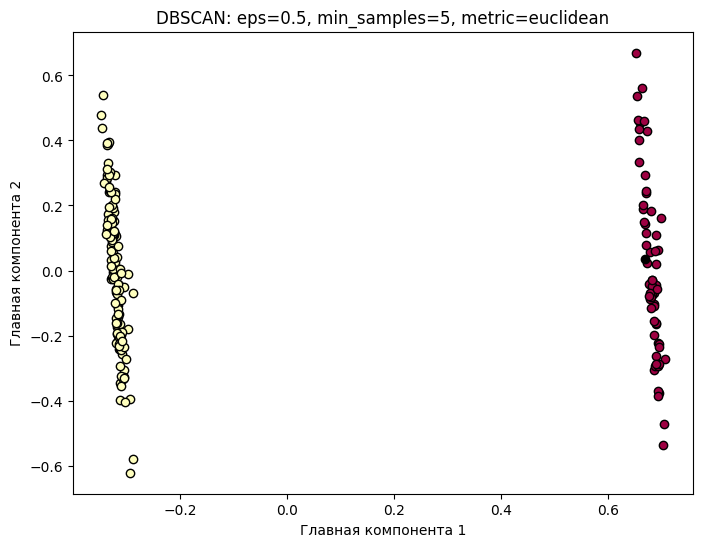

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

После применения алгоритма DBSCAN мы получили **два кластера**, между которыми наблюдаются существенные различия по некоторым признакам. Рассмотрим три наиболее значимых признака:

1. **Type_White (Тип вина):**
   - **Кластер 0** состоит исключительно из красных вин (значение `mean = 0.0`).
   - **Кластер 1** состоит исключительно из белых вин (значение `mean = 1.0`).

2. **Volatile Acidity:**
   - **Кластер 0** (красные вина) имеет более высокое среднее значение летучей кислотности (`mean ≈ 0.299`), чем **Кластер 1** (белые вина) со средним значением (`mean ≈ 0.132`).

3. **Total Sulfur Dioxide:**
   - **Кластер 1** (белые вина) имеет значительно более высокое среднее содержание общего диоксида серы (`mean ≈ 0.305`), в сравнении с **Кластером 0** (красные вина) со средним значением (`mean ≈ 0.093`).

**Коэффициент силуэта для DBSCAN:** 0.6136

**Общее заключение:**

Алгоритм DBSCAN успешно разделил вина на два кластера по типу (красное и белое), при этом выявив существенные различия в летучей кислотности и содержании диоксида серы между ними.



 выделили два кластера (0 и 1) на основе различных признаков, связанных с артериальным давлением, весом, холестерином и выживаемостью. Кластер 0 содержит 63 наблюдения, а кластер 1 — 136 наблюдений.

МОИ признаки и их интерпретация

1. SBP_50 (Систолическое артериальное давление):

   • Кластер 0: Среднее значение 0.327, стандартное отклонение 0.157, минимальное значение 0.098, максимальное 0.918.

   • Кластер 1: Среднее значение 0.289, стандартное отклонение 0.144, минимальное значение 0.000, максимальное 1.000.

   • Вывод: Кластер 0 имеет более высокое среднее значение систолического давления по сравнению с кластером 1, что может указывать на более высокие уровни давления среди участников этого кластера.

2. DBP_50 (Диастолическое артериальное давление):

   • Кластер 0: Среднее значение 0.444, стандартное отклонение 0.116, минимальное значение 0.265, максимальное 1.000.

   • Кластер 1: Среднее значение 0.445, стандартное отклонение 0.105, минимальное значение 0.000, максимальное 0.706.

   • Вывод: Средние значения диастолического давления практически одинаковы между кластерами, однако кластер 1 имеет более широкий диапазон значений (от 0 до 0.706).

3. HT_50 (Рост):

   • Кластер 0: Среднее значение 0.499, стандартное отклонение 0.206, минимальное значение 0.071, максимальное 0.929.

   • Кластер 1: Среднее значение 0.517, стандартное отклонение 0.195, минимальное значение 0.000, максимальное 1.000.

   • Вывод: Кластер 1 имеет немного более высокое среднее значение по сравнению с кластером 0.

4. WT_50 (Вес):

   • Кластер 0: Среднее значение 0.415, стандартное отклонение 0.234, минимальное значение 0.000, максимальное 0.926.

   • Кластер 1: Среднее значение 0.443, стандартное отклонение 0.177, минимальное значение 0.081, максимальное 1.000.

   • Вывод: Кластер 1 показывает более высокое среднее значение веса по сравнению с кластером 0.

5. CHOL_50 (Холестерин):

   • Кластер 0: Среднее значение 0.316, стандартное отклонение 0.112, минимальное значение 0.092, максимальное 0.586.

   • Кластер 1: Среднее значение 0.336, стандартное отклонение 0.131, минимальное значение 0.000, максимальное 0.769.

   • Вывод: Кластер 1 также имеет немного более высокое среднее значение уровня холестерина.

Коэффициент силуэта для DBSCAN: 0.5849: Значение в диапазоне от 0 до 1 говорит о том, что кластеры достаточно хорошо отделены друг от друга и имеют хорошую плотность внутри каждого кластера. Значение около 0.58 указывает на умеренно хорошую кластеризацию.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [11]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 223.0171
Индекс Дэвиса-Болдина для K-means: 1.2083
Коэффициент силуэта для K-means: 0.3393


In [12]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 338.9023
Индекс Дэвиса-Болдина для DBSCAN: 0.6732
Коэффициент силуэта для DBSCAN: 0.5849


#### Визуальный пример

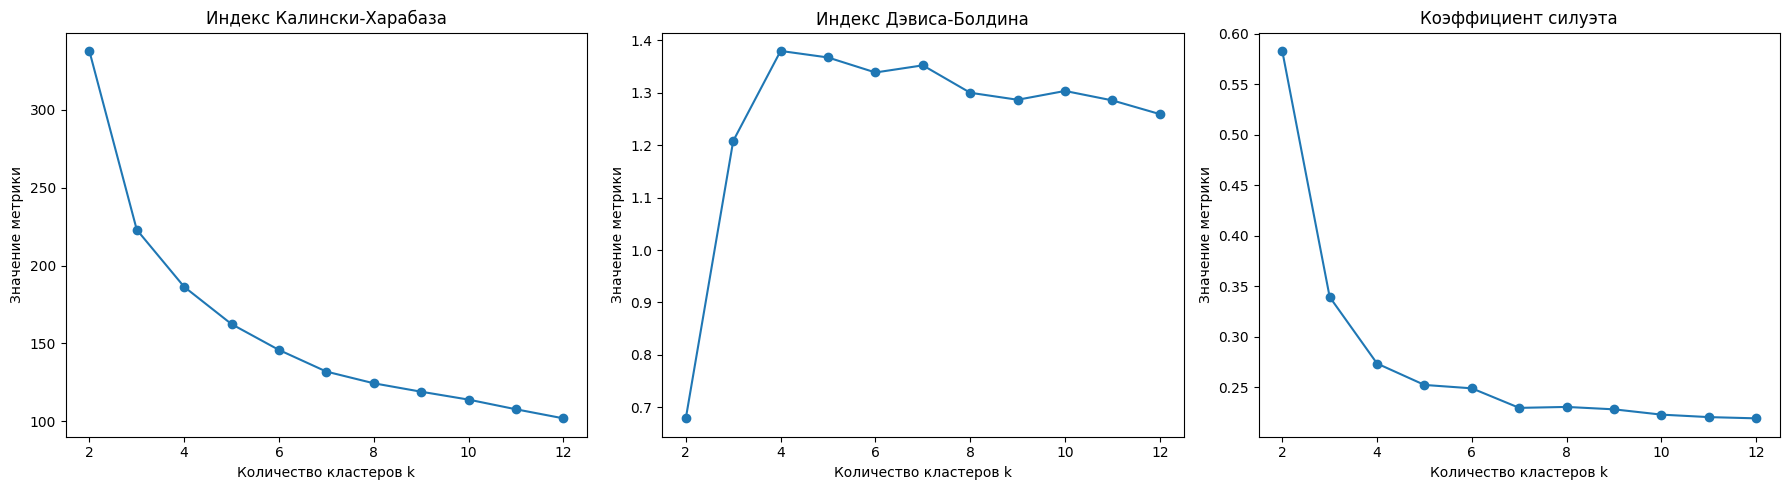

In [13]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(df, labels)
    db_score = davies_bouldin_score(df, labels)
    silhouette_avg = silhouette_score(df, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()
